<a href="https://colab.research.google.com/github/harihardiyan/DiracEngine/blob/main/notebooks/DiracEngine_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:

# Clone repo (skip if running inside the repo already)
!git clone https://github.com/harihardiyan/DiracEngine.git
%cd DiracEngine

# Add src/ to Python path
import sys
sys.path.append('src')

# Basic imports
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

Cloning into 'DiracEngine'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 125 (delta 48), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (125/125), 128.33 KiB | 5.83 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/DiracEngine/DiracEngine


In [ ]:

import engine as DE

build_dirac_engine = DE.build_dirac_engine
GRAPHENE_KM_IDEAL = DE.GRAPHENE_KM_IDEAL

engine = build_dirac_engine(GRAPHENE_KM_IDEAL)
engine["spec"]

DiracGrapheneSpec(name='graphene_kane_mele_ideal', vF=1.0e+06 m/s, Delta=0.00e+00 eV, lambda_SO=1.00e-03 eV, lambda_R=5.00e-03 eV)

In [ ]:

def compute_wilson_with_visuals(engine, tau, band_idx, kmax, grid, gap_eps):
    ks = jnp.linspace(-kmax, kmax, grid)
    KX, KY = jnp.meshgrid(ks, ks, indexing="ij")

    eigvals, eigvecs = jnp.vectorize(
        lambda kx, ky: engine["eigsys"](kx, ky, tau),
        signature="(),()->(n),(n,n)"
    )(KX, KY)

    # Gap map
    gaps_below = jnp.where(
        band_idx > 0,
        eigvals[..., band_idx] - eigvals[..., band_idx-1],
        jnp.inf
    )
    gaps_above = jnp.where(
        band_idx < 3,
        eigvals[..., band_idx+1] - eigvals[..., band_idx],
        jnp.inf
    )
    gap_map = np.array(jnp.minimum(gaps_below, gaps_above))

    phases = []
    masks = []
    Q = 0

    def link(a, b):
        ov = jnp.vdot(a, b)
        return jnp.exp(-1j * jnp.angle(ov))

    for i in range(grid-1):
        for j in range(grid-1):
            gmin = float(min(
                gap_map[i,j], gap_map[i+1,j],
                gap_map[i,j+1], gap_map[i+1,j+1]
            ))

            u00 = eigvecs[i, j][:, band_idx]
            u10 = eigvecs[i+1, j][:, band_idx]
            u01 = eigvecs[i, j+1][:, band_idx]
            u11 = eigvecs[i+1, j+1][:, band_idx]

            W = link(u00, u10) * link(u10, u11) * jnp.conj(link(u01, u11)) * jnp.conj(link(u00, u01))
            phase = float(jnp.angle(W))
            phase_over_2pi = phase / (2*np.pi)

            phases.append(phase_over_2pi)
            masks.append(gmin < gap_eps)

            if gmin >= gap_eps:
                Q += round(phase_over_2pi)

    return Q, np.array(phases), np.array(masks), gap_map

In [ ]:

Q, phases, masks, gaps = compute_wilson_with_visuals(
    engine,
    tau=+1,
    band_idx=1,
    kmax=5e8,
    grid=41,
    gap_eps=1e-6 * 1.602e-19
)

Q

0

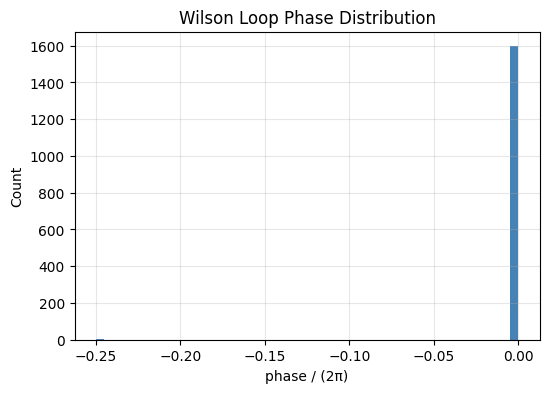

In [ ]:

plt.figure(figsize=(6,4))
plt.hist(phases, bins=50, color='steelblue')
plt.xlabel("phase / (2π)")
plt.ylabel("Count")
plt.title("Wilson Loop Phase Distribution")
plt.grid(True, alpha=0.3)
plt.savefig("figures/wilson_phase_hist.png", dpi=150)
plt.show()

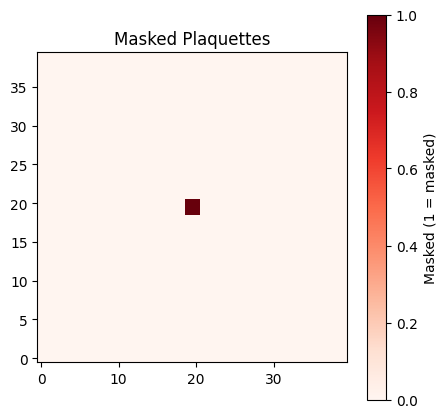

In [ ]:

plt.figure(figsize=(5,5))
plt.imshow(masks.reshape(40, 40), cmap='Reds', origin='lower')
plt.colorbar(label="Masked (1 = masked)")
plt.title("Masked Plaquettes")
plt.savefig("figures/masked_map.png", dpi=150)
plt.show()

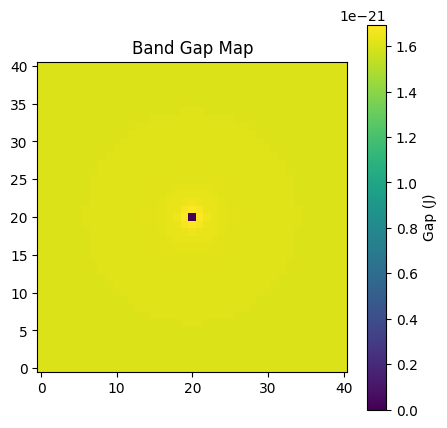

In [ ]:

plt.figure(figsize=(5,5))
plt.imshow(gaps, cmap='viridis', origin='lower')
plt.colorbar(label="Gap (J)")
plt.title("Band Gap Map")
plt.savefig("figures/band_gap_map.png", dpi=150)
plt.show()

In [ ]:

thetas, omega = engine["probe_kubo_on_ring"](
    jnp.array([0.0, 0.0]),
    tau=+1,
    band_idx=1,
    radius=5e8,
    n_theta=128
)

plt.figure(figsize=(6,4))
plt.plot(np.array(thetas), np.array(omega))
plt.xlabel("θ (radians)")
plt.ylabel("Ω(θ)")
plt.title("Kubo Berry Curvature Along Ring")
plt.grid(True, alpha=0.3)
plt.savefig("figures/kubo_ring.png", dpi=150)
plt.show()

In [ ]:

print("Wilson loop topological charge Q =", Q)
print("Figures saved to /figures/")